Εισάγουμε όλα τα πακέτα που θα χρειαστούμε στην εργασία μας.

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fotis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fotis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Διαβάζουμε τα δεδομένα μας και κοιτάμε το σχήμα τους.

In [3]:
url='amazon.tsv'
#url='https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Personal_Care_Appliances_v1_00.tsv.gz
Data=pd.read_csv(url,sep='\t',error_bad_lines=False)
Data.shape

b'Skipping line 1598: expected 15 fields, saw 22\nSkipping line 25768: expected 15 fields, saw 22\n'


(85924, 15)

Πετάμε τα NA's. Τελικά ήταν μόνο 5 γραμμές, οπότε δεν υπάρχει πρόβλημα να τα αγνοήσουμε. 

In [4]:
Data=Data.dropna(axis=0)
Data.shape

(85919, 15)

Οι στήλες 'marketplace','review_id' και 'product_category' δεν προσφέρουν κάποια επιπλέον πληροφορία, άρα μπορούν να αφαιρεθούν.

In [4]:
Data=Data.drop(columns=['marketplace','review_id','product_category'],axis=1)

Οι στήλες 'product_parent','product_title' και 'product_id' προσφέρουν την ίδια πληροφορία. Θα κρατήσουμε αυτή με τις λιγότερες μοναδικές εγγραφές, αφού δείχνει καλύτερη κατηγοριοποίηση.

In [5]:
print('product_parent: ',len(Data['product_parent'].unique()),
      '\nproduct_title: ',len(Data['product_title'].unique()),
      '\nproduct_id: ',len(Data['product_id'].unique()))

product_parent:  15916 
product_title:  16938 
product_id:  17559


In [6]:
Data=Data.drop(columns=['product_id','product_title'],axis=1)

Ενώνουμε τα 'review_headline' και 'review_body' σε μία νέα στήλη, ώστε να υπάρχει όλο το κείμενο της κάθε κριτικής. Έπειτα ορίζουμε νέα μεταβλητή που δείχνει το πλήθος χαρακτήρων της κάθε κριτικής.

In [7]:
Data['review']=Data['review_headline'].map(str) +' - ' +Data['review_body'] 

In [8]:
Data=Data.drop(columns=['review_headline','review_body'],axis=1)

In [9]:
Data['review_length']=np.asarray(Data['review'].str.len())

Ορίζουμε νέο Dataframe στο οποίο εξετάζουμε τη βαθμολογία ανά προϊόν. Ομαδοποιούνται μέσω της στήλης 'product_parent'.

In [10]:
Products={}
for i,j in Data.iterrows():    
      if(j['product_parent'] in Products):        
              Products[j['product_parent']].append(j['star_rating'])        
      else:        
              Products[j['product_parent']]=[j['star_rating']] 
Mean=[]
Prod=[]
SD=[]
N=[]
for i in Products:
    Mean.append(np.asarray(Products[i]).mean())
    Prod.append(i)
    SD.append(np.asarray(Products[i]).std())
    N.append(len(Products[i]))
    
Product_Stat={'Product':Prod,
             'Rating':Mean,
             'SD':SD,
             'Number':N}

Product_Stat=pd.DataFrame(Product_Stat)   

In [11]:
pd.DataFrame(Product_Stat.drop(columns=['Product','SD']).describe())

,Rating,Number
count,15916.000000,15916.000000
mean,3.771768,5.398278
std,1.339065,41.076646
min,1.000000,1.000000
25%,3.000000,1.000000
50%,4.000000,1.000000
75%,5.000000,3.000000
max,5.000000,3918.000000


Αναπαριστούμε γραφικά την πυκνότητα πιθανότητας της βαθμολογίας των προϊόντων.

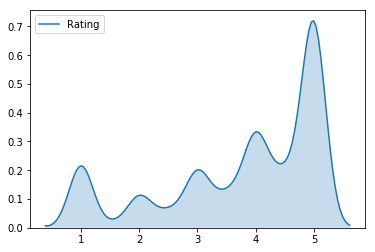

In [12]:
sns.kdeplot(Product_Stat.Rating,shade=True)

Εξετάζουμε τη συχνότητα των λέξεων στις καλές (3,4,5 αστέρια) και κακές (1,2 αστέρια) κριτικές. Το αναπαριστούμε γραφικά με ραβδόγραμμα.

In [13]:
Positive={}
for i in Data[Data['star_rating']>2.5]['review']:
    Word_List=word_tokenize(i)
    for j in Word_List:
        if(j in Positive):
            Positive[j]+=1
        else:
            Positive[j]=1            
Keys=[] 
Values=[]
stop_words=set(stopwords.words("english"))
stop_words.update(['br','It','This','The'])
for i in Positive:
    if(i not in stop_words and i.isalpha()):   
        Keys.append(i)
        Values.append(Positive[i])
Positive_Stat={'Pos_Word':Keys,'Count':Values}
Positive_Stat=pd.DataFrame(Positive_Stat) 
Positive_Stat=Positive_Stat.sort_values(['Count'],ascending=False)   
Positive_Stat[1:10]

,Pos_Word,Count
44,product,22889
16,use,20841
208,one,20839
8,great,18775
53,like,15227
175,good,15072
52,would,14118
243,get,13567
198,well,12596


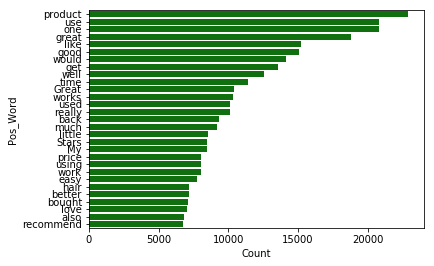

In [14]:
sns.barplot(x="Count",y="Pos_Word",data=Positive_Stat[1:30],color="g")

In [15]:
Negative={}
for i in Data[Data['star_rating']<2.5]['review']:
    Word_List=word_tokenize(i)
    for j in Word_List:
        if(j in Negative):
            Negative[j]+=1
        else:
            Negative[j]=1            
Keys1=[] 
Values1=[]
stop_words=set(stopwords.words("english"))
stop_words.update(['br','It','This','The'])
for i in Negative:
    if(i not in stop_words and i.isalpha()):   
        Keys1.append(i)
        Values1.append(Negative[i])
Negative_Stat={'Neg_Word':Keys1,'Count':Values1}
Negative_Stat=pd.DataFrame(Negative_Stat) 
Negative_Stat=Negative_Stat.sort_values(['Count'],ascending=False)   
Negative_Stat[1:10]

,Neg_Word,Count
39,product,6742
44,would,5534
106,one,5353
34,work,3849
62,use,3821
100,get,3765
153,like,3367
140,money,2969
37,time,2961


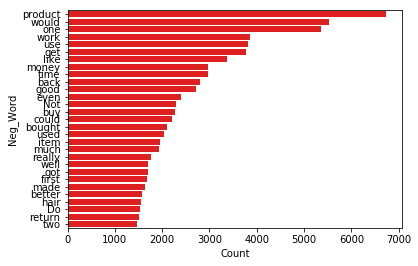

In [16]:
sns.barplot(x="Count",y="Neg_Word",data=Negative_Stat[1:30],color="r")

Συναρτήσεις πυκνότητας πιθανότητας κατανομής ψήφων στις κριτικές και μήκους χαρακτήρων.

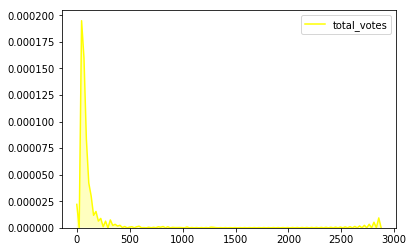

In [17]:
sns.kdeplot(Data['total_votes'],shade=True,color="yellow")

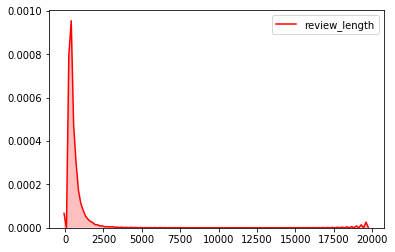

In [18]:
sns.kdeplot(Data['review_length'],shade=True,color="red")

Εξετάζοντας συσχετίσεις μεταξύ μεταβλητών, φαίνεται ότι είναι τελείως γραμμική η συσχέτιση των 'helpful_votes','total_votes'. Οπότε αφαιρούμε τη στήλη 'helpful_votes' (θα μπορούσε αντίστοιχα να αφαιρεθεί η 'total_votes' χωρίς κάποια αλλαγή).

In [19]:
cleandata=pd.DataFrame()
cleandata['star_rating']=Data['star_rating']
cleandata['total_votes']=Data['total_votes']
cleandata['helpful_votes']=Data['helpful_votes']
cleandata['review_length']=Data['review_length']
cleandata.corr()

,star_rating,total_votes,helpful_votes,review_length
star_rating,1.000000,-0.030357,-0.008671,-0.038069
total_votes,-0.030357,1.000000,0.991686,0.271167
helpful_votes,-0.008671,0.991686,1.000000,0.271205
review_length,-0.038069,0.271167,0.271205,1.000000


In [20]:
Data=Data.drop(columns=['helpful_votes'])

Μετατρέπουμε τις τιμές 'Ν','Υ' σε ακεραίους.

In [21]:
Data=Data.replace(['N','Y'],[0,1])

Αναζητούμε τις πιο συχνές λέξεις ανά βαθμολογία που έδωσε η κριτική. Μέσα από αυτές φτιάχνουμε απλά σύνολα λέξεων, και από εκεί ορίζουμε νέες στήλες, που θα παίρνουν ακέραιες αριθμητικές τιμές όσες το πλήθος των λέξεων από κάθε κατηγορία που περιέχει η κριτική.

In [22]:
Word_5={}
for i in Data[Data['star_rating']==5]['review']:
    Word_List_5=word_tokenize(i)
    for j in Word_List_5:
        if(j in Word_5):
            Word_5[j]+=1
        else:
            Word_5[j]=1            
Keys_5=[] 
Values_5=[]
stop_words=set(stopwords.words("english"))
stop_words.update(['would','like','product','use','one','br','It','This','The'])
for i in Word_5:
    if(i not in stop_words and i.isalpha()):   
        Keys_5.append(i)
        Values_5.append(Word_5[i])
Word_5_Stat={'Pos_Word':Keys_5,'Count':Values_5}
Word_5_Stat=pd.DataFrame(Word_5_Stat) 
Word_5_Stat=Word_5_Stat.sort_values(['Count'],ascending=False)   
five_starwds=Word_5_Stat[1:10]['Pos_Word']

Word_4={}
for i in Data[Data['star_rating']==4]['review']:
    Word_List_4=word_tokenize(i)
    for j in Word_List_4:
        if(j in Word_4):
            Word_4[j]+=1
        else:
            Word_4[j]=1            
Keys_4=[] 
Values_4=[]
for i in Word_4:
    if(i not in stop_words and i.isalpha()):   
        Keys_4.append(i)
        Values_4.append(Word_4[i])
Word_4_Stat={'Pos_Word':Keys_4,'Count':Values_4}
Word_4_Stat=pd.DataFrame(Word_4_Stat) 
Word_4_Stat=Word_4_Stat.sort_values(['Count'],ascending=False)   
four_starwds=Word_4_Stat[1:10]['Pos_Word']

Word_3={}
for i in Data[Data['star_rating']==3]['review']:
    Word_List_3=word_tokenize(i)
    for j in Word_List_3:
        if(j in Word_3):
            Word_3[j]+=1
        else:
            Word_3[j]=1            
Keys_3=[] 
Values_3=[]
for i in Word_3:
    if(i not in stop_words and i.isalpha()):   
        Keys_3.append(i)
        Values_3.append(Word_3[i])
Word_3_Stat={'Pos_Word':Keys_3,'Count':Values_3}
Word_3_Stat=pd.DataFrame(Word_3_Stat) 
Word_3_Stat=Word_3_Stat.sort_values(['Count'],ascending=False)   
three_starwds=Word_3_Stat[1:10]['Pos_Word']

Word_2={}
for i in Data[Data['star_rating']==2]['review']:
    Word_List_2=word_tokenize(i)
    for j in Word_List_2:
        if(j in Word_2):
            Word_2[j]+=1
        else:
            Word_2[j]=1            
Keys_2=[] 
Values_2=[]
for i in Word_2:
    if(i not in stop_words and i.isalpha()):   
        Keys_2.append(i)
        Values_2.append(Word_2[i])
Word_2_Stat={'Pos_Word':Keys_2,'Count':Values_2}
Word_2_Stat=pd.DataFrame(Word_2_Stat) 
Word_2_Stat=Word_2_Stat.sort_values(['Count'],ascending=False)   
two_starwds=Word_2_Stat[1:10]['Pos_Word']

Word_1={}
for i in Data[Data['star_rating']==1]['review']:
    Word_List_1=word_tokenize(i)
    for j in Word_List_1:
        if(j in Word_1):
            Word_1[j]+=1
        else:
            Word_1[j]=1            
Keys_1=[] 
Values_1=[]
for i in Word_1:
    if(i not in stop_words and i.isalpha()):   
        Keys_1.append(i)
        Values_1.append(Word_1[i])
Word_1_Stat={'Pos_Word':Keys_1,'Count':Values_1}
Word_1_Stat=pd.DataFrame(Word_1_Stat) 
Word_1_Stat=Word_1_Stat.sort_values(['Count'],ascending=False)   
one_starwds=Word_1_Stat[1:10]['Pos_Word']

words1=set(one_starwds)
words2=set(two_starwds)
words3=set(three_starwds)
words4=set(four_starwds) 
words5=set(five_starwds) 
print(words1,'\n',words2,'\n',words3,'\n',words4,'\n',words5,'\n')

{'work', 'money', 'good', 'back', 'even', 'get', 'time', 'buy', 'could'} 
 {'work', 'really', 'well', 'good', 'back', 'Not', 'get', 'time', 'much'} 
 {'work', 'really', 'well', 'great', 'good', 'works', 'get', 'time', 'better'} 
 {'really', 'well', 'great', 'good', 'works', 'little', 'used', 'get', 'time'} 
 {'really', 'well', 'great', 'good', 'works', 'used', 'get', 'Great', 'time'} 



In [22]:
temp1=set(['One','one','bad','return','waste','not'])
temp2=set(['Two','two','much','back','better','money'])
temp3=set(['Three','three','price','well','used','really'])
temp4=set(['Four','four','good','time','works'])
temp5=set(['Five','five','great','love','recommend','easy'])

In [23]:
def one_search(df):
    return (len(set(word_tokenize(df.review)))-len(set(word_tokenize(df.review))-temp1))
def two_search(df):
    return (len(set(word_tokenize(df.review)))-len(set(word_tokenize(df.review))-temp2))
def three_search(df):
    return (len(set(word_tokenize(df.review)))-len(set(word_tokenize(df.review))-temp3))
def four_search(df):
    return (len(set(word_tokenize(df.review)))-len(set(word_tokenize(df.review))-temp4))
def five_search(df):
    return (len(set(word_tokenize(df.review)))-len(set(word_tokenize(df.review))-temp5))

In [24]:
Data['one_star']=Data.apply(one_search,axis=1)
Data['two_star']=Data.apply(two_search,axis=1)
Data['three_star']=Data.apply(three_search,axis=1)
Data['four_star']=Data.apply(four_search,axis=1)
Data['five_star']=Data.apply(five_search,axis=1)

Η μεγαλύτερή μας κλάση έχει 57%, άρα τόσο είναι το baseline προβλεπτικής ικανότητας του μοντέλου μας.

In [25]:
len(Data[Data.star_rating==5])/len(Data)

0.5686867863918341

Εκπαιδεύουμε το μοντέλο μας χρησιμοποιώντας KNN, Random Forest και Gaussian Naive Bayes. Αρχικά έχουμε τιμές κάτω του baseline.

In [27]:
features = Data.filter(['vine','verified_purchase', 'review_length','total_votes',
                        'one_star','two_star','three_star','four_star','five_star'], axis=1)
labels=Data['star_rating']

In [28]:
x_train, x_test, y_train, y_test =train_test_split(features,labels,test_size=0.33)

In [33]:
rfc.fit(x_train,y_train)
knn.fit(x_train,y_train)
gnb.fit(x_train,y_train)

C:\Users\Fotis\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GaussianNB(priors=None, var_smoothing=1e-09)

In [35]:
pred_rfc=rfc.predict(x_test)
print(accuracy_score(pred_rfc,y_test))

0.4985187275163998


In [36]:
pred_knn=knn.predict(x_test)
print(accuracy_score(pred_knn,y_test))

0.5101925654228681


In [37]:
pred_gnb=gnb.predict(x_test)
print(accuracy_score(pred_gnb,y_test))

0.5328701417789378


Χρησιμοποιούμε τον Random Over Sampler από το imblearn ώστε να διορθώσουμε το πρόβλημα των imbalanced δεδομένων. Αυξάνει τις μειονοτικές κλάσεις.

In [31]:
feat,lab=ros.fit_resample(features,labels)

In [32]:
train,test,yt,y=train_test_split(feat,lab,test_size=0.33)

In [33]:
rfc.fit(train,yt)
knn.fit(train,yt)
gnb.fit(train,yt)

C:\Users\Fotis\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GaussianNB(priors=None, var_smoothing=1e-09)

In [34]:
pred1_rfc=rfc.predict(x_test)
print(accuracy_score(pred1_rfc,y_test))

0.7733300416167032


In [35]:
pred1_knn=knn.predict(x_test)
print(accuracy_score(pred1_knn,y_test))

0.5448966636100726


In [36]:
pred1_gnb=gnb.predict(x_test)
print(accuracy_score(pred1_gnb,y_test))

0.36714396557804896


In [38]:
confusion_matrix(y_test,pred1_rfc)

array([[ 3226,   127,   135,    97,    88],
       [   38,  1615,    40,    21,    21],
       [   51,    60,  2085,    56,    49],
       [  142,   182,   221,  3645,   249],
       [ 1015,   858,  1189,  1788, 11356]], dtype=int64)

In [39]:

def plot_confusion_matrix(y_true, y_pred, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [1,2,3,4,5]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Παρατηρούμε ότι δουλεύει πολύ καλά με τον Random Forest, ενώ χειροτερεύει τους άλλους δύο Classifiers. Παίρνουμε τελικά προβλεπτική ικανότητα 77%, έχοντας πολύ καλύτερη ικανότητα διάκρισης στις μικρές κλάσεις του αρχικού dataset. Μειώθηκε λίγο η προβλεπτική ικανότητα στη μεγαλύτερη κλάση, λόγω του over sampling στις μικρές.

Normalized confusion matrix
[[0.87830112 0.03457664 0.0367547  0.02640893 0.02395862]
 [0.02190202 0.93083573 0.02305476 0.01210375 0.01210375]
 [0.02216428 0.02607562 0.90612777 0.02433724 0.02129509]
 [0.03198919 0.04100023 0.04978599 0.82113089 0.05609371]
 [0.06263112 0.05294335 0.07336789 0.11032951 0.70072813]]


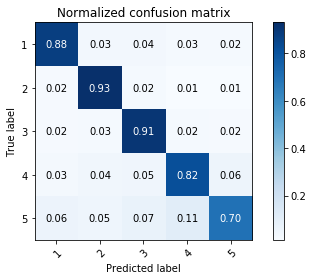

In [40]:
plot_confusion_matrix(y_test,pred1_rfc,normalize=True)

Τέλος κατασκευάζουμε την καμπύλη μάθησης του μοντέλου. Παρατηρούμε ότι χρειάζεται περίπου 80000 δείγματα για να πάει πάνω από 70%. Αυτό εξηγεί την ανάγκη του random over sampler, καθώς είχαμε μικρό αρχικό dataset, εκτός από imbalanced. Σίγουρα η καλύτερη λύση είναι η συλλογή περισσότερων δεδομένων, αλλά το over sampling είναι μία επιλογή εάν δεν υπάρχουν τα δεδομένα αυτά.

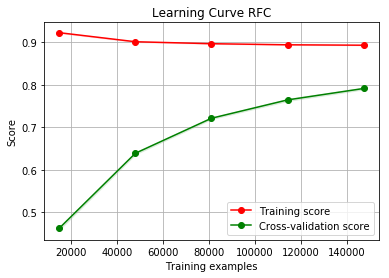

In [44]:



def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):


    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt




title = r"Learning Curve RFC"
estimator = rfc
plot_learning_curve(estimator, title, train, yt, cv=10, n_jobs=4)

plt.show()